# Part 2b: Advanced Design Space Exploration

In this notebook, we will leverage Python programming to scan the design space of our HLS model.

## Setup

As we did in the previous notebooks, let's import the libraries, call the magic functions, and setup the environment variables.

In [1]:
from tensorflow.keras.utils import to_categorical
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import hls4ml

%matplotlib inline

import os
os.environ['PATH'] = '/tools/Xilinx/Vivado/2019.1/bin:' + os.environ['PATH']

def is_tool(name):
    from distutils.spawn import find_executable
    return find_executable(name) is not None

print('-----------------------------------')
if not is_tool('vivado_hls'):
    print('Xilinx Vivado HLS is NOT in the PATH')
else:
    print('Xilinx Vivado HLS is in the PATH')
print('-----------------------------------')

-----------------------------------
Xilinx Vivado HLS is in the PATH
-----------------------------------


### Load the dataset and the model

In [Part 1](part1_getting_started.ipynb), we saved the preprocessed dataset and model to files. Let's load them.

In [2]:
# Load dataset
X_train_val = np.load('X_train_val.npy')
X_test = np.load('X_test.npy')
y_train_val = np.load('y_train_val.npy')
y_test = np.load('y_test.npy', allow_pickle=True)
classes = np.load('classes.npy', allow_pickle=True)

# Load Keras model
from tensorflow.keras.models import load_model
model = load_model('model_1/KERAS_check_best_model.h5')
y_keras = model.predict(X_test)

## DSE

Let's combine everything together Python programming and `Precision` and `Reuse Factor` knobs.

First we encapsulate in a function the creation of a hls4ml configuration dictionary and hls4ml model creation, compilation and built (C-synthesis).

In [3]:
import time
import multiprocessing


def process_hls4ml(model, fxd_w, fxd_i, rf, fpga_part, dse_hls_results):
    # Generate a hls4ml configuration dictionary from the Keras model
    config = hls4ml.utils.config_from_keras_model(model, granularity='Model')
    # Update the knobs
    config['Model']['ReuseFactor'] = rf
    config['Model']['Precision'] = 'ap_fixed<' + str(fxd_w) + ',' + str(fxd_i) + '>'
    
    # Create an HLS model from the Keras model and the updated hls4ml configuration dictionary
    hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                           hls_config=config,
                                                           output_dir='model_1/hls4ml_prj_rf' + str(rf),
                                                           fpga_part=fpga_part)
    _ = hls_model.compile()

    start_time = time.time()
    hls_results = hls_model.build(csim=False)
    exec_time = time.time() - start_time

    hls_results["ExecutionTime"] = exec_time
    hls_results["WbitsFixedPoint"] = fxd_w
    hls_results["IbitsFixedPoint"] = fxd_i
    hls_results["FPGApart"] = fpga_part
    dse_hls_results[rf] = hls_results    

Use `multiprocessing` package to run multiple synthesis runs in parallel.

**ATTENTION: Pay attention to the amount of CPU cores/threads available on your host!**

In [4]:
%%time

target_fpga_part='xczu7ev-ffvc1156-2-e' # ZCU106
#target_fpga_part='xczu3eg-sbva484-1-e' # Ultra96
#target_fpga_part='xc7z020clg400-1' # Pynq-Z1
#target_fpga_part='xc7z007sclg225-1' # Minized

# Explore the Cartesian product of ReuseFactor and Precision
reuse_factor_values = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
fxd_w_values = [16]
fxd_i_values = [6]

# Append here the processes
processes = list()

# DSE results shared among processes
manager = multiprocessing.Manager()
dse_hls_results = manager.dict()

# Swipe over the Precision and ReuseFactor values and spawn synthesis processes
for fxd_w in fxd_w_values:
    for fxd_i in fxd_i_values:
        for rf in reuse_factor_values:
            t = multiprocessing.Process(target=process_hls4ml, args=(model, fxd_w, fxd_i, rf, target_fpga_part, dse_hls_results))
            processes.append(t)
            t.start()

# Wait for completion
for t in processes:
    t.join()

CPU times: user 104 ms, sys: 131 ms, total: 235 ms
Wall time: 41min 22s


Print DSE results on console.

In [5]:
def print_hls_results(hls_results):
    print('-----------------------------------')
    #print(hls_results) # Print hashmap
    print("FPGA part: {}".format(hls_results['FPGApart']))
    print("Fixed-Point Word Size: {}".format(hls_results['WbitsFixedPoint']))
    print("Fixed-Point Integer-Part Size: {}".format(hls_results['IbitsFixedPoint']))
    print("Execution Time: {} s".format(hls_results['ExecutionTime']))
    print("Estimated Clock Period: {} ns".format(hls_results['EstimatedClockPeriod']))
    print("Best/Worst Latency:     {} / {}".format(hls_results['BestLatency'], hls_results['WorstLatency']))
    print("Interval Min/Max:       {} / {}".format(hls_results['IntervalMin'], hls_results['IntervalMax']))
    print("BRAM_18K:               {} (Aval. {})".format(hls_results['BRAM_18K'], hls_results['AvailableBRAM_18K']))
    print("DSP48E:                 {} (Aval. {})".format(hls_results['DSP48E'], hls_results['AvailableDSP48E']))
    print("FF:                     {} (Aval. {})".format(hls_results['FF'], hls_results['AvailableFF']))
    print("LUT:                    {} (Aval. {})".format(hls_results['LUT'], hls_results['AvailableLUT']))
    print("URAM:                   {} (Aval. {})".format(hls_results['URAM'], hls_results['AvailableURAM']))
    print('-----------------------------------')

for rf in dse_hls_results.keys():
    print_hls_results(dse_hls_results[rf])

-----------------------------------
FPGA part: xczu7ev-ffvc1156-2-e
Fixed-Point Word Size: 16
Fixed-Point Integer-Part Size: 6
Execution Time: 1575.5010974407196 s
Estimated Clock Period: 5.195 ns
Best/Worst Latency:     75 / 75
Interval Min/Max:       16 / 16
BRAM_18K:               2 (Aval. 624)
DSP48E:                 271 (Aval. 1728)
FF:                     54231 (Aval. 460800)
LUT:                    115548 (Aval. 230400)
URAM:                   0 (Aval. 96)
-----------------------------------
-----------------------------------
FPGA part: xczu7ev-ffvc1156-2-e
Fixed-Point Word Size: 16
Fixed-Point Integer-Part Size: 6
Execution Time: 2259.6143028736115 s
Estimated Clock Period: 5.685 ns
Best/Worst Latency:     135 / 135
Interval Min/Max:       32 / 32
BRAM_18K:               2 (Aval. 624)
DSP48E:                 138 (Aval. 1728)
FF:                     60531 (Aval. 460800)
LUT:                    115298 (Aval. 230400)
URAM:                   0 (Aval. 96)
--------------------------

Define a plot 2D function.

In [6]:
import matplotlib.pyplot as plt
import collections
import matplotlib.ticker as plticker
import numpy as np


def plot_hls_results(dse_hls_results, resource_label, unit='HLS Estimates', available_resources=True, show_values=False, show_precision=True, xscale_log=False, yscale_log=False):
    
    dse_hls_results_ordered = collections.OrderedDict(sorted(dse_hls_results.items(), key=lambda x:x[0], reverse=False))
    
    #print(sorted(dse_hls_results.items(), key=lambda x:x[0], reverse=False))
    
    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 14

    plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=BIGGER_SIZE)     # fontsize of the x and y labels
    plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)   # fontsize of the figure title
    
    reuse_factor_x_axis = np.array(list(dse_hls_results_ordered.keys()))
    resource_usage_y_axis = []
    fxd_w_precision = []
    fxd_i_precision = []
    resource_available_y_axis=[]
    fpga_parts=[]
    for i, d in dse_hls_results_ordered.items():
        resource_usage_y_axis.append(int(dse_hls_results_ordered[i][resource_label]))
    if (available_resources):
        for i, d in dse_hls_results_ordered.items():
            resource_available_y_axis.append(int(dse_hls_results_ordered[i]['Available' + resource_label]))
    for i, d in dse_hls_results_ordered.items():
        fxd_w_precision.append(int(dse_hls_results_ordered[i]['WbitsFixedPoint']))
    for i, d in dse_hls_results_ordered.items():
        fxd_i_precision.append(int(dse_hls_results_ordered[i]['IbitsFixedPoint']))
    for i, d in dse_hls_results_ordered.items():
        fpga_parts.append(dse_hls_results_ordered[i]['FPGApart'])

    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlabel('Reuse Factor')
    
    ax.set_ylabel(resource_label + ' (' + unit + ')')

    ax.plot(reuse_factor_x_axis, resource_usage_y_axis, linestyle='--', marker='o')
    
    if (available_resources):
        ax.axhline(y=resource_available_y_axis[0], color='r', linestyle='-', label = resource_label + ' (Available)')
        ax.legend(loc='upper right')

    ax.set_xticks(reuse_factor_x_axis)
    
    ax.grid(True)

    plt.figtext(0.90, 0.90, 'hls4ml', fontweight='bold', wrap=True, horizontalalignment='right', fontsize=14)
    plt.figtext(0.4, 0.90, fpga_parts[0], wrap=True, horizontalalignment='right', fontsize=14)
    
    if xscale_log: ax.set_xscale('log', base=2)
    if yscale_log: ax.set_yscale('log', base=2)
    
    #ax.xaxis.set_minor_formatter(plticker.ScalarFormatter())
    
    if show_values:
        for x,y in zip(reuse_factor_x_axis,resource_usage_y_axis):
            label = "{:d}".format(y)
            plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center
    if show_precision:
        for x,y,w,i in zip(reuse_factor_x_axis,resource_usage_y_axis,fxd_w_precision,fxd_i_precision):
            label = '<{},{}>'.format(w,i)
            plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

Plot some of the resources from the previous DSE.

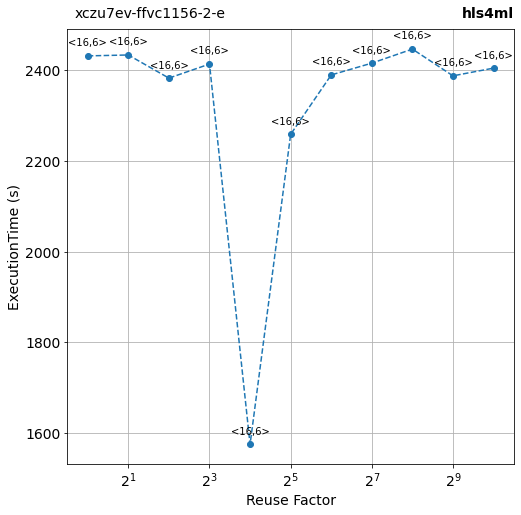

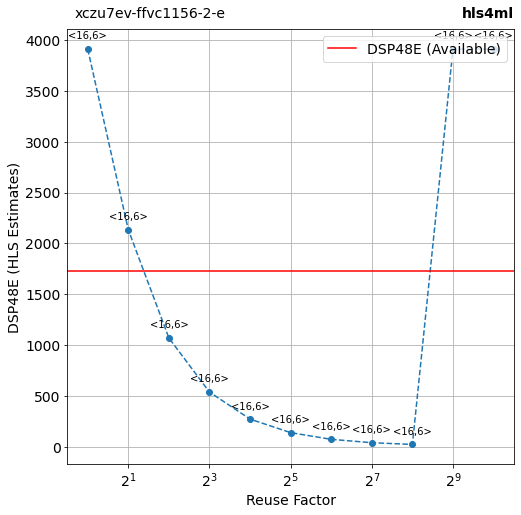

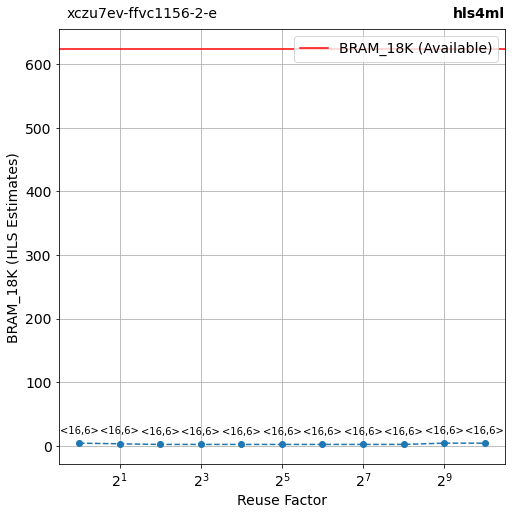

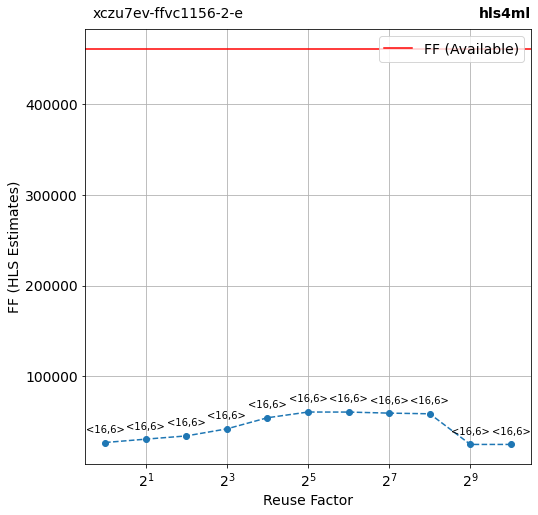

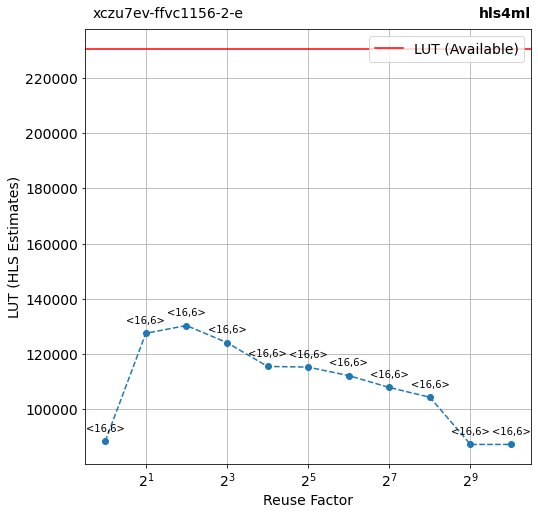

In [7]:
plot_hls_results(dse_hls_results, 'ExecutionTime', unit='s', available_resources=False, xscale_log=True)
plot_hls_results(dse_hls_results, 'DSP48E', xscale_log=True)
plot_hls_results(dse_hls_results, 'BRAM_18K', xscale_log=True)
plot_hls_results(dse_hls_results, 'FF', xscale_log=True)
plot_hls_results(dse_hls_results, 'LUT', xscale_log=True)

Save DSE results on file for future reference.

In [8]:
import json
json = json.dumps(dse_hls_results.copy())
f = open("dse_hls_results.json","w")
f.write(json)
f.close()

Load DSE results from file.

In [9]:
import json 

with open('dse_hls_results.json') as json_file: 
    data = json.load(json_file) 
  
    # Print the type of data variable 
    print(data)

{'16': {'EstimatedClockPeriod': '5.195', 'BestLatency': '75', 'WorstLatency': '75', 'IntervalMin': '16', 'IntervalMax': '16', 'BRAM_18K': '2', 'DSP48E': '271', 'FF': '54231', 'LUT': '115548', 'URAM': '0', 'AvailableBRAM_18K': '624', 'AvailableDSP48E': '1728', 'AvailableFF': '460800', 'AvailableLUT': '230400', 'AvailableURAM': '96', 'ExecutionTime': 1575.5010974407196, 'WbitsFixedPoint': 16, 'IbitsFixedPoint': 6, 'FPGApart': 'xczu7ev-ffvc1156-2-e'}, '32': {'EstimatedClockPeriod': '5.685', 'BestLatency': '135', 'WorstLatency': '135', 'IntervalMin': '32', 'IntervalMax': '32', 'BRAM_18K': '2', 'DSP48E': '138', 'FF': '60531', 'LUT': '115298', 'URAM': '0', 'AvailableBRAM_18K': '624', 'AvailableDSP48E': '1728', 'AvailableFF': '460800', 'AvailableLUT': '230400', 'AvailableURAM': '96', 'ExecutionTime': 2259.6143028736115, 'WbitsFixedPoint': 16, 'IbitsFixedPoint': 6, 'FPGApart': 'xczu7ev-ffvc1156-2-e'}, '4': {'EstimatedClockPeriod': '4.766', 'BestLatency': '25', 'WorstLatency': '25', 'IntervalMi

## Exercises

- Use `Pool` Python package to allocate a number of synthesis non bigger than the number of CPU cores/threads.
- DSE at the same time over `Precision` and `ReuseFactor`.
- 3D plotting (?)